## 데이터불러오기

In [1]:
import pandas as pd 

In [2]:
df_player=pd.read_csv('player_box_data.csv')
df_injury= pd.read_csv('injury_sparse.csv')


## 경기 데이터

In [3]:
import pandas as pd

# 데이터 로드
df = df_player
# 필요한 변수 선택 (필요 없는 변수 제거)
columns_to_keep = ['PLAYER', 'TEAM', 'MATCH UP', 'GAME DATE', 'W/L', 'MIN', 'PTS', 'FG%', '3P%', 'FT%', 
                   'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', '+/-', 'FP', 'Season']
df = df[columns_to_keep]

# 날짜 형식 변환
df['GAME DATE'] = pd.to_datetime(df['GAME DATE'])

# 파생 변수 1: 홈 경기 여부
# MATCH UP에서 "@"가 있으면 원정, 없으면 홈 경기
df['HOME'] = df['MATCH UP'].apply(lambda x: 0 if "@" in x else 1)

# 파생 변수 2: 시간 간격 (이전 경기와의 간격, 일 단위)
df = df.sort_values(by=['PLAYER', 'GAME DATE'])  # 선수별로 날짜 정렬
df['TIME_GAP'] = df.groupby('PLAYER')['GAME DATE'].diff().dt.days  # 이전 경기와의 간격
df['TIME_GAP'] = df['TIME_GAP'].fillna(0).astype(int)  # NaN(첫 경기)은 0으로 대체


/var/folders/gl/6qlsk6x94klgs54qzsg9q1jm0000gn/T/ipykernel_2469/3005580842.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GAME DATE'] = pd.to_datetime(df['GAME DATE'])
/var/folders/gl/6qlsk6x94klgs54qzsg9q1jm0000gn/T/ipykernel_2469/3005580842.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['HOME'] = df['MATCH UP'].apply(lambda x: 0 if "@" in x else 1)


In [4]:

player_df=df[['PLAYER','GAME DATE' ,'W/L', 'MIN', 'PTS', 'FG%', '3P%', 'FT%','REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', '+/-','HOME','TIME_GAP']]
player_df.head()

,PLAYER,GAME DATE,W/L,MIN,PTS,FG%,3P%,FT%,REB,AST,STL,BLK,TOV,PF,+/-,HOME,TIME_GAP
21218,A.J. Lawson,2022-11-16,W,2,2,100,-,-,1,0,0,0,0,1,-5,0,0
14750,A.J. Lawson,2022-12-29,W,1,0,0.0,0.0,-,0,0,0,0,0,0,-4,1,43
13650,A.J. Lawson,2023-01-05,L,4,0,0.0,0.0,-,0,0,0,0,0,0,-6,1,7
13267,A.J. Lawson,2023-01-07,W,1,0,-,-,-,0,0,0,0,0,0,2,1,2
13099,A.J. Lawson,2023-01-08,L,2,0,0.0,0.0,-,0,0,0,0,0,0,-1,0,1


In [5]:
player_df.groupby('PLAYER').count().max()
player_df.shape

(25895, 17)

In [6]:
kk=player_df['PLAYER'].value_counts().reset_index()
p_list=kk.query('count >= 41').PLAYER.to_list()
pf=player_df.query('PLAYER in @p_list')


In [7]:
pf=player_df.query('PLAYER in @p_list')
pf.PLAYER.value_counts()

PLAYER
Mikal Bridges       83
Patrick Williams    82
Nikola Vučević      82
Harrison Barnes     82
Kevon Looney        82
                    ..
T.J. Warren         42
Max Christie        41
Damian Jones        41
Blake Griffin       41
Lindy Waters III    41
Name: count, Length: 349, dtype: int64

In [8]:
# pf.query('PLAYER =="Patrick Williams" ')
# pf.query('GAME DATE=="2022-10-18"')
# pf[pf['GAME DATE']=="2022-10-18"]


In [9]:
import pandas as pd
import numpy as np

# 데이터 로드
player_df = pf.copy()  # 주어진 데이터프레임 사용

# 날짜 범위 생성 (모든 날짜를 포함하는 범위)
date_range = pd.date_range(start=player_df['GAME DATE'].min(), end=player_df['GAME DATE'].max())
def create_3d_data(df, date_range):
    players = df['PLAYER'].unique()  # 모든 선수 리스트
    feature_columns = ['MIN', 'PTS', 'FG%', '3P%', 'FT%', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', '+/-', 'HOME', 'TIME_GAP']
    player_3d_data = []

    for player in players:
        # 선수별 데이터 필터링
        player_data = df[df['PLAYER'] == player].copy()

        # 날짜를 인덱스로 설정하고 모든 날짜에 대해 데이터 재구성
        player_data = player_data.set_index('GAME DATE').reindex(date_range, fill_value=0)

        # 숫자형 변환: 모든 열을 float으로 변환, 변환 불가능한 값은 0으로 대체
        for col in feature_columns:
            player_data[col] = pd.to_numeric(player_data[col], errors='coerce').fillna(0)

        # 날짜를 다시 열로 추가 (필요 없는 경우 제거 가능)
        player_data['GAME DATE'] = player_data.index

        # 필요한 열만 유지
        player_data = player_data[feature_columns]

        # 2D 데이터를 리스트에 추가
        player_3d_data.append(player_data.values)

    # 3D 배열 생성
    player_3d_array = np.array(player_3d_data, dtype=np.float32)  # 모든 데이터를 float32로 변환
    return player_3d_array, players, feature_columns

# 3D 데이터 생성
player_3d_array, players, feature_columns = create_3d_data(player_df, date_range)

In [10]:

# 결과 확인
print(f"3D 배열의 shape: {player_3d_array.shape}")
print(f"3D 배열의 데이터 타입: {player_3d_array.dtype}")


3D 배열의 shape: (349, 174, 14)
3D 배열의 데이터 타입: float32


In [11]:
len(players)

349

## 부상데이터

In [12]:
# 선수 이름이 포함된 열만 필터링
filtered_columns = [col for col in df_injury.columns if col in players]

# 필터링된 데이터프레임 생성
filtered_df = df_injury[filtered_columns]

# 포함되지 않은 선수들 구하기
missing_players = [player for player in players if player not in df_injury.columns]
len(missing_players)

121

In [13]:
# 선수 이름이 포함된 열만 필터링
filtered_columns = [col for col in df_injury.columns if col in players]

# 필터링된 데이터프레임 생성
filtered_df = df_injury[filtered_columns]

# 포함되지 않은 선수들 구하기
missing_players = [player for player in players if player not in df_injury.columns]

# 포함되지 않은 선수들에 대해 새로운 열 추가 (모두 0으로 초기화)
for player in missing_players:
    filtered_df[player] = 0

# 열 순서 정렬 (players 순서대로)
filtered_df = filtered_df[players]


/var/folders/gl/6qlsk6x94klgs54qzsg9q1jm0000gn/T/ipykernel_2469/3773304415.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[player] = 0
/var/folders/gl/6qlsk6x94klgs54qzsg9q1jm0000gn/T/ipykernel_2469/3773304415.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[player] = 0
/var/folders/gl/6qlsk6x94klgs54qzsg9q1jm0000gn/T/ipykernel_2469/3773304415.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

In [14]:
filtered_df

,AJ Griffin,Aaron Gordon,Aaron Holiday,Aaron Nesmith,Aaron Wiggins,Al Horford,Alec Burks,Alex Caruso,Alperen Sengun,Amir Coffey,...,Walker Kessler,Wendell Carter Jr.,Wenyen Gabriel,Wesley Matthews,Will Barton,Xavier Tillman,Yuta Watanabe,Zach Collins,Zach LaVine,Zeke Nnaji
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
889,0,0,1,0,0,0,1,1,0,0,...,0,1,0,0,0,1,1,1,1,1
890,0,0,1,0,0,0,1,1,0,0,...,0,1,0,0,0,1,1,1,1,1
891,0,0,1,0,0,0,1,1,0,0,...,0,1,0,0,0,1,1,1,1,1
892,0,0,1,0,0,0,1,1,0,0,...,0,1,0,0,0,1,1,1,1,1


In [15]:
import numpy as np

# 부상 데이터를 3차원으로 변환
def reshape_injury_data(filtered_df):
    # 데이터프레임을 NumPy 배열로 변환
    injury_data = filtered_df.values  # shape: (894, 349)
    
    # 각 선수별 데이터를 reshape
    injury_3d = injury_data.T.reshape(filtered_df.shape[1], filtered_df.shape[0], 1)  # (349, 894, 1)
    
    return injury_3d


# 3차원 부상 데이터 생성
injury_3d = reshape_injury_data(filtered_df)


In [16]:
# 새로운 열 추가: 저번 부상까지 몇 경기 차이인지 계산
def add_games_since_last_injury_with_no_injury_case(injury_3d):
    # injury_3d: shape (players, dates, 1)
    num_players, num_dates, _ = injury_3d.shape

    # 새로운 데이터를 저장할 배열 생성 (players, dates, 2)
    expanded_3d_array = np.zeros((num_players, num_dates, 2), dtype=np.float32)
    expanded_3d_array[:, :, 0] = injury_3d[:, :, 0]  # 첫 번째 채널에 기존 부상 데이터를 복사

    # 각 선수별로 처리
    for player_idx in range(num_players):
        last_injury_idx = -1  # 마지막 부상의 인덱스를 초기화
        has_injury = False  # 부상이 한 번이라도 있었는지 여부 확인
        for date_idx in range(num_dates):
            if injury_3d[player_idx, date_idx, 0] == 1:  # 부상이 발생한 경우
                last_injury_idx = date_idx  # 현재 인덱스를 마지막 부상 인덱스로 갱신
                has_injury = True  # 부상이 있었음을 표시
            
            # 이전 부상이 없었던 경우 처리
            if last_injury_idx == -1:
                expanded_3d_array[player_idx, date_idx, 1] = -1  # 부상 경험이 없는 경우 -1
            else:
                # 현재 날짜와 마지막 부상 날짜 간 차이를 계산
                expanded_3d_array[player_idx, date_idx, 1] = date_idx - last_injury_idx
        
        # 부상이 한 번도 없었던 선수 처리
        if not has_injury:
            expanded_3d_array[player_idx, :, 1] = -1  # 모든 날짜를 -1로 설정
    
    return expanded_3d_array

# 새로운 3D 데이터 생성
expanded_injury_3d = add_games_since_last_injury_with_no_injury_case(injury_3d)

print(f"최종 데이터 shape: {expanded_injury_3d.shape}")


최종 데이터 shape: (349, 894, 2)


In [17]:
player_3d_array.shape # 
# expanded_injury_3d.shape # 독립변수 값 
# injury_3d # target값 
# injury_3d=expanded_injury_3d.copy()

(349, 174, 14)

(70,)

In [40]:
y_test = injury_3d[:, -1, 0]  # (349,) 형태로 추출
print(y_test.shape)

X_player_train = player_3d_array[:, :-1, :]  # 마지막 경기 제외
X_injury_train = expanded_injury_3d[:, :-1, :]  # 마지막 경기 제외
print(y_test.shape)
print(X_player_train.shape)
print(X_injury_train.shape)
# 최신 데이터를 포함한 입력 데이터 준비
X_player_test = player_3d_array[:, 1:, :]  # 첫 번째 경기 제외하고 최신 데이터 포함 (349, 173, 14)
X_injury_test = expanded_injury_3d[:, 1:, :]  # 첫 번째 경기 제외하고 최신 데이터 포함 (349, 893, 2)

# 데이터 shape 확인
print(f"X_player_test shape: {X_player_test.shape}")  # (349, 173, 14)
print(f"X_injury_test shape: {X_injury_test.shape}")  # (349, 893, 2)



(349,)
(349,)
(349, 173, 14)
(349, 893, 2)
X_player_test shape: (349, 173, 14)
X_injury_test shape: (349, 893, 2)


In [41]:
# Train/Validation Split
train_size = int(0.8 * len(X_player_train))

X_player_train_seq = X_player_train[:train_size]
X_player_val_seq = X_player_train[train_size:]

X_injury_train_seq = X_injury_train[:train_size]
X_injury_val_seq = X_injury_train[train_size:]

y_train_seq = y_test[:train_size]  # 수정: 올바른 y_train을 사용해야 함
y_val_seq = y_test[train_size:]

y_train_seq.shape
y_val_seq.shape

(70,)

In [42]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_injury_train_scaled = scaler.fit_transform(X_injury_train.reshape(-1, X_injury_train.shape[-1])).reshape(X_injury_train.shape)
# X_injury_test_scaled = scaler.fit_transform(X_injury_test.reshape(-1, X_injury_test.shape[-1])).reshape(X_injury_test.shape)

# X_player_train_scaled = scaler.fit_transform(X_player_train.reshape(-1, X_player_train.shape[-1])).reshape(X_player_train.shape)
# X_player_test_scaled = scaler.transform(X_player_test.reshape(-1, X_player_test.shape[-1])).reshape(X_player_test.shape)


## transformer modeling

In [47]:
# ! pip install transformers

In [45]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, MultiHeadAttention, LayerNormalization, Dropout, Lambda, Concatenate,Layer
from tensorflow.keras.models import Model
class PositionalEncoding(Layer):
    def __init__(self, embed_dim):
        super(PositionalEncoding, self).__init__()
        self.embed_dim = embed_dim

    def call(self, inputs):
        seq_len = tf.shape(inputs)[1]
        positions = tf.range(seq_len, dtype=tf.float32)[:, tf.newaxis]
        dims = tf.range(self.embed_dim, dtype=tf.float32)[tf.newaxis, :]
        
        # 수정된 부분: tf.math.floordiv 사용
        angles = positions / tf.pow(10000.0, (2 * tf.math.floordiv(dims, 2)) / self.embed_dim)
        pos_encoding = tf.concat([tf.sin(angles[:, 0::2]), tf.cos(angles[:, 1::2])], axis=-1)
        return inputs + pos_encoding[tf.newaxis, :seq_len, :]


# Transformer 인코더 블록 정의
class TransformerEncoderBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1):
        super(TransformerEncoderBlock, self).__init__()
        self.attention = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)

    def call(self, inputs, training=False):
        attn_output = self.attention(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# 모델 정의
def build_transformer_model(player_input_shape, injury_input_shape, embed_dim, num_heads, ff_dim, dropout_rate=0.1):
    # 선수 경기 데이터 입력
    player_inputs = Input(shape=player_input_shape, name="player_input")
    # 부상 데이터 입력
    injury_inputs = Input(shape=injury_input_shape, name="injury_input")

    # 임베딩 레이어 추가 (입력 차원을 embed_dim으로 맞춤) + 포지셔널 인코딩
    player_embedded = PositionalEncoding(embed_dim)(Dense(embed_dim)(player_inputs))
    injury_embedded = PositionalEncoding(embed_dim)(Dense(embed_dim)(injury_inputs))

    # Transformer 인코더 블록
    transformer_block_player = TransformerEncoderBlock(embed_dim, num_heads, ff_dim, dropout_rate)
    transformer_block_injury = TransformerEncoderBlock(embed_dim, num_heads, ff_dim, dropout_rate)

    # 선수 데이터 Transformer 인코더 처리
    player_encoded = transformer_block_player(player_embedded)
    player_last_step = Lambda(lambda x: x[:, -1, :])(player_encoded)  # 마지막 시점

    # 부상 데이터 Transformer 인코더 처리
    injury_encoded = transformer_block_injury(injury_embedded)
    injury_last_step = Lambda(lambda x: x[:, -1, :])(injury_encoded)  # 마지막 시점

    # 두 인코더 출력 결합
    combined = Concatenate()([player_last_step, injury_last_step])

    # 완전 연결층
    dense1 = Dense(256, activation="relu")(combined)
    dropout1 = Dropout(0.3)(dense1)
    dense2 = Dense(128, activation="relu")(dropout1)
    dropout2 = Dropout(0.3)(dense2)
    output = Dense(1, activation="sigmoid", name="output")(dropout2)  # 이진 분류

    # 모델 정의
    model = Model(inputs=[player_inputs, injury_inputs], outputs=output)
    return model

# 모델 생성
embed_dim = 64
num_heads = 4
ff_dim = 128
dropout_rate = 0.1

player_input_shape = (173, 14)  # X_player_train shape: (349, 173, 14)
injury_input_shape = (893, 2)   # X_injury_train shape: (349, 893, 2)

model = build_transformer_model(player_input_shape, injury_input_shape, embed_dim, num_heads, ff_dim, dropout_rate)

# 모델 컴파일
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss="binary_crossentropy",
              metrics=["accuracy"])



In [46]:
print(y_test.shape)
print(X_player_train.shape)
print(X_injury_train.shape)

(349,)
(349, 173, 14)
(349, 893, 2)


In [28]:

print(f"y_test 크기: {y_test.shape}")


y_test 크기: (0,)


In [38]:
# 모델 학습
history = model.fit(
    [X_player_train_seq, X_injury_train_seq],
    y_train_seq,
    validation_data=([X_player_val_seq, X_injury_val_seq], y_val_seq),
    batch_size=32,
    epochs=30,
    callbacks=[early_stopping]
)

# 모델 평가
loss, accuracy = model.evaluate([X_player_val_seq, X_injury_val_seq], y_val_seq)
print(f"Validation Accuracy: {accuracy:.4f}")


Epoch 1/30


/opt/anaconda3/envs/kmy_env/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['player_input', 'injury_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.6324 - loss: 0.6672 - val_accuracy: 0.7143 - val_loss: 0.5628
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6881 - loss: 0.5500 - val_accuracy: 0.7143 - val_loss: 0.5705
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.7488 - loss: 0.5084 - val_accuracy: 0.7429 - val_loss: 0.5590
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.7150 - loss: 0.4925 - val_accuracy: 0.7857 - val_loss: 0.5366
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.7438 - loss: 0.5243 - val_accuracy: 0.7714 - val_loss: 0.5264
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.7137 - loss: 0.5294 - val_accuracy: 0.7857 - val_loss: 0.5044
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.7461 - loss: 0.5010 - val_accuracy: 0.8143 - val_loss: 0.5021
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.7859 - loss: 0.4832 - val_accuracy: 0.8000 - val_loss: 0.4949
Epoch 9/30
9/9 ━━━━

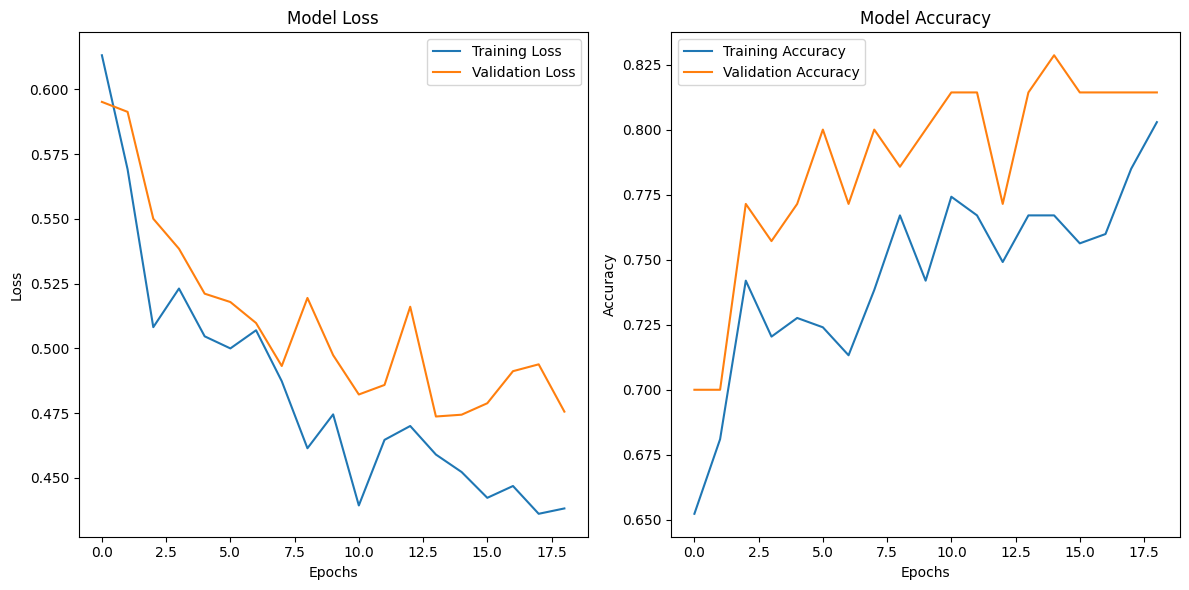

In [22]:
import matplotlib.pyplot as plt

# 학습 기록(history)에서 loss와 accuracy 시각화
def plot_history(history):
    # 손실(Loss)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 정확도(Accuracy)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 호출
plot_history(history)



In [86]:
# 데이터 타입 확인
print(train_injury.dtype)  # 예: dtype('int32') or dtype('int')
print(train_performance.dtype)
print(train_y.dtype)


int64
float32
int64


In [50]:
# TensorFlow에서 호환 가능한 타입으로 변환
train_injury = train_injury.astype("float32")
test_injury = test_injury.astype("float32")

train_performance = train_performance.astype("float32")
test_performance = test_performance.astype("float32")

train_y = train_y.astype("float32")  # 라벨도 float32로 변환
test_y = test_y.astype("float32")

## 부상확률 예측 

In [23]:
# 최신 데이터를 포함한 입력 데이터 준비
X_player_test = player_3d_array[:, 1:, :]  # 첫 번째 경기 제외하고 최신 데이터 포함 (349, 173, 14)
X_injury_test = expanded_injury_3d[:, 1:, :]  # 첫 번째 경기 제외하고 최신 데이터 포함 (349, 893, 2)

# 데이터 shape 확인
print(f"X_player_test shape: {X_player_test.shape}")  # (349, 173, 14)
print(f"X_injury_test shape: {X_injury_test.shape}")  # (349, 893, 2)


X_player_test shape: (349, 173, 14)
X_injury_test shape: (349, 893, 2)


In [24]:
# 훈련된 모델로 예측
y_pred = model.predict([X_player_test, X_injury_test])  # 최신 데이터로 예측

# 예측 결과 확인
print(f"y_pred shape: {y_pred.shape}")  # (349,)
print(f"y_pred: {y_pred[:10]}")  # 예측된 결과 샘플 출력


/opt/anaconda3/envs/kmy_env/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['player_input', 'injury_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 591ms/step
y_pred shape: (349, 1)
y_pred: [[0.07015765]
 [0.37529865]
 [0.31920305]
 [0.07190298]
 [0.08030608]
 [0.24977073]
 [0.40854463]
 [0.27076146]
 [0.06176199]
 [0.31252748]]


In [26]:
# 모델 예측 (뒤쪽 데이터를 사용)
predictions = model.predict([X_player_test, X_injury_test])

# 결과 출력
for i, prob in enumerate(predictions):
    print(f"Player {i + 1}: Injury Probability for 175th Game = {prob[0]:.4f}")


11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 574ms/step
Player 1: Injury Probability for 175th Game = 0.0702
Player 2: Injury Probability for 175th Game = 0.3753
Player 3: Injury Probability for 175th Game = 0.3192
Player 4: Injury Probability for 175th Game = 0.0719
Player 5: Injury Probability for 175th Game = 0.0803
Player 6: Injury Probability for 175th Game = 0.2498
Player 7: Injury Probability for 175th Game = 0.4085
Player 8: Injury Probability for 175th Game = 0.2708
Player 9: Injury Probability for 175th Game = 0.0618
Player 10: Injury Probability for 175th Game = 0.3125
Player 11: Injury Probability for 175th Game = 0.3034
Player 12: Injury Probability for 175th Game = 0.0625
Player 13: Injury Probability for 175th Game = 0.4306
Player 14: Injury Probability for 175th Game = 0.5783
Player 15: Injury Probability for 175th Game = 0.1211
Player 16: Injury Probability for 175th Game = 0.0944
Player 17: Injury Probability for 175th Game = 0.0628
Player 18: Injury Probability for 175th Game = 0.1

In [28]:


# DataFrame 생성
data = {'Player': players, 'Injury_probability': [prob[0] for prob in predictions]}
df = pd.DataFrame(data)
df.to_csv('injury_prob2.csv', index=False)